In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [2]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [61]:
HSB106 = sc.read(inpath+"HSB106.h5ad")
HSB189 = sc.read(inpath+"HSB189.h5ad")
HSB340 = sc.read(inpath+"HSB340.h5ad")

# Read Metadata

In [ ]:
metadata = pd.read_excel('Metadata2.xlsx')

In [62]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

In [ ]:
metadata

# Fix Metadata 

In [63]:
tmp1 = metadata.loc[metadata['SampleID'] == "HSB106"].loc[metadata.loc[metadata['SampleID'] == "HSB106"].index.repeat(HSB106.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "HSB106-" + tmp1.index.astype(str),inplace=True) 
HSB106.obs = tmp1


In [64]:
tmp1 = metadata.loc[metadata['SampleID'] == "HSB189"].loc[metadata.loc[metadata['SampleID'] == "HSB189"].index.repeat(HSB189.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "HSB189-" + tmp1.index.astype(str),inplace=True) 
HSB189.obs = tmp1


In [65]:
tmp1 = metadata.loc[metadata['SampleID'] == "HSB340"].loc[metadata.loc[metadata['SampleID'] == "HSB340"].index.repeat(HSB340.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "HSB340-" + tmp1.index.astype(str),inplace=True) 
HSB340.obs = tmp1


# Concatenate 

In [66]:
HSB106.var_names_make_unique()
HSB189.var_names_make_unique()
HSB340.var_names_make_unique()

In [67]:
adata = HSB106.concatenate(HSB189,HSB340,
                         index_unique=None)

In [68]:
del(HSB106,HSB189,HSB340)

In [69]:
print(adata.obs['SampleID'].value_counts())
adata

HSB106    6946
HSB340    5620
HSB189    4527
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 17093 × 23476
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'

In [70]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [71]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [72]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [73]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [74]:
adata

AnnData object with n_obs × n_vars = 17093 × 23476
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


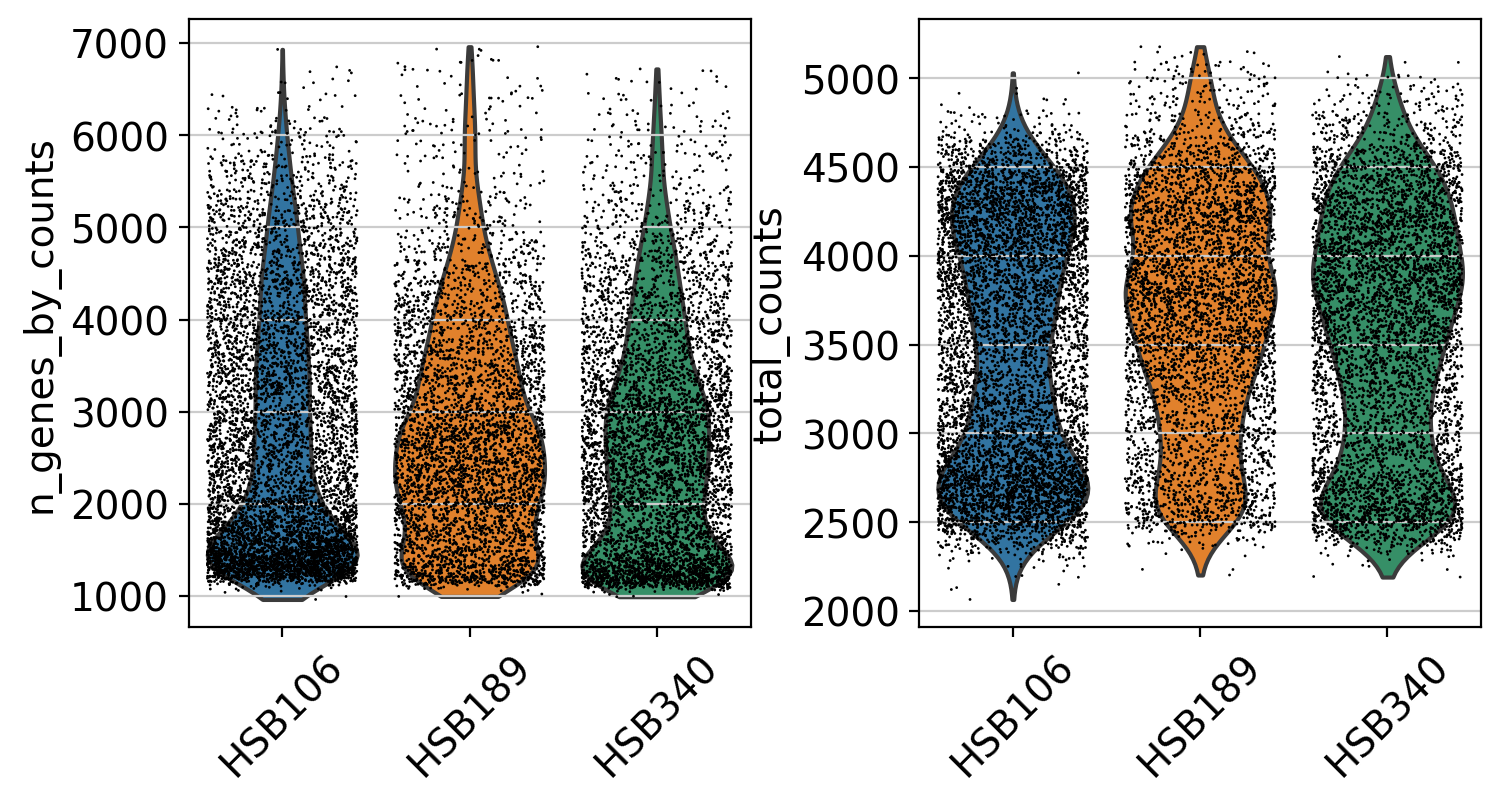

In [75]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

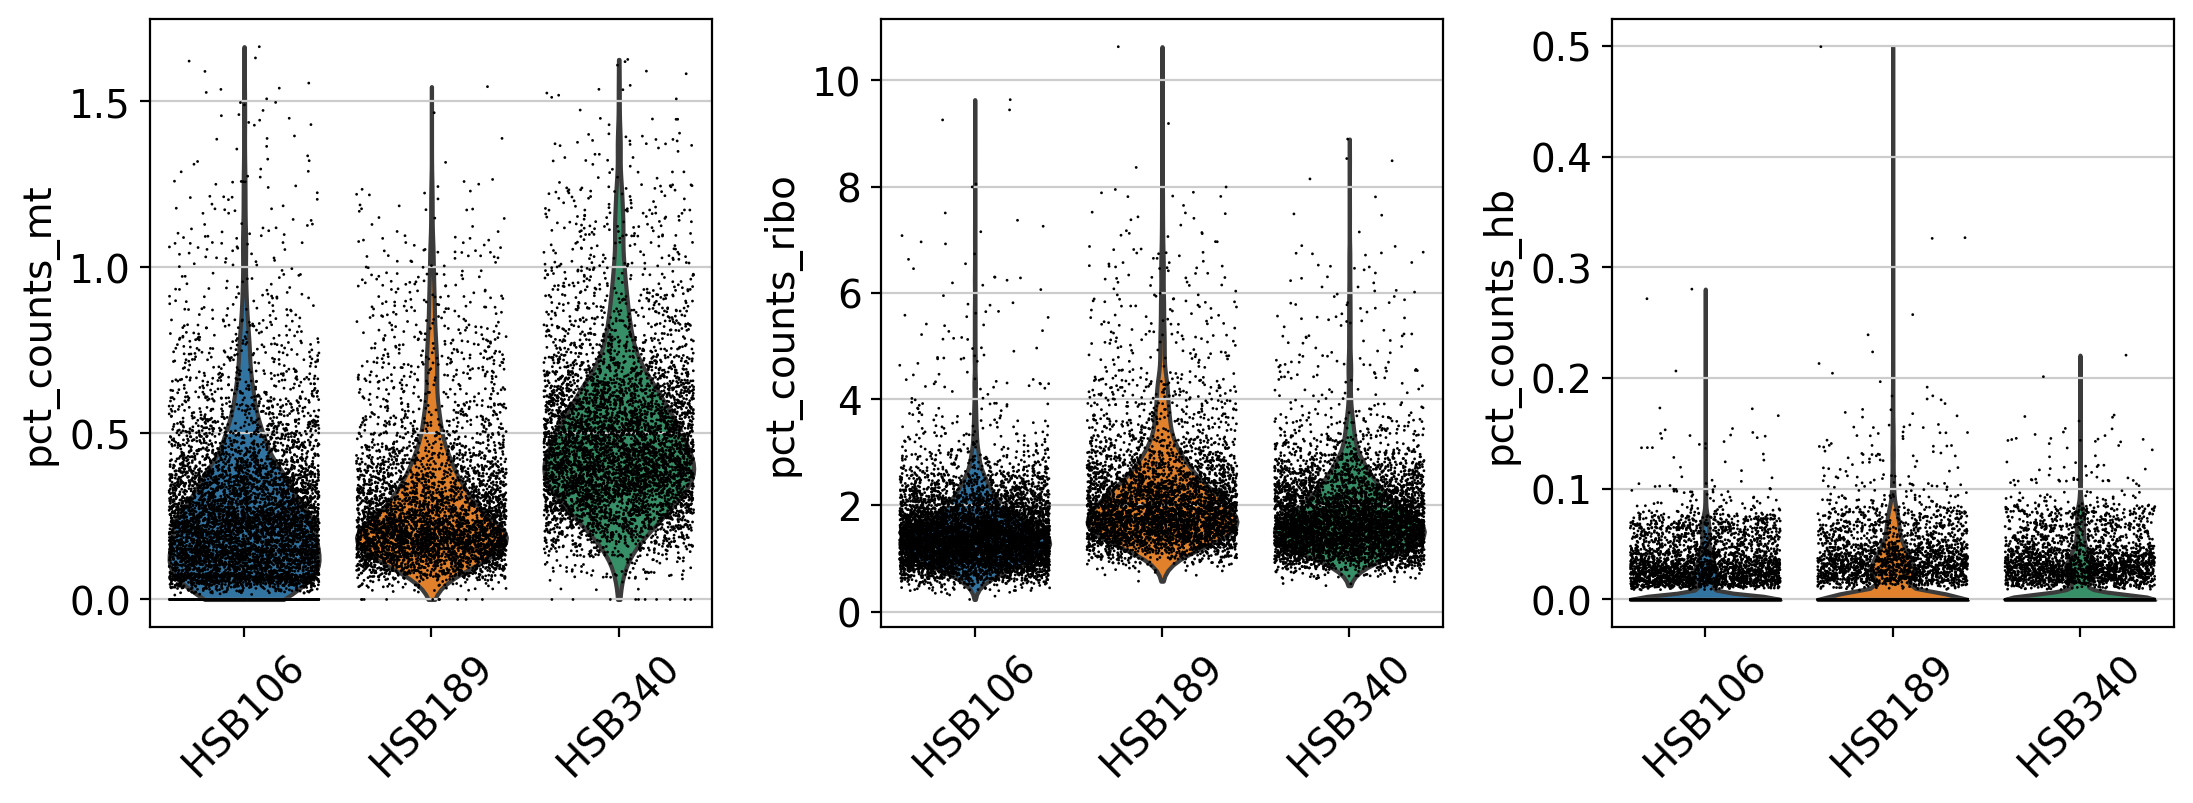

In [76]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

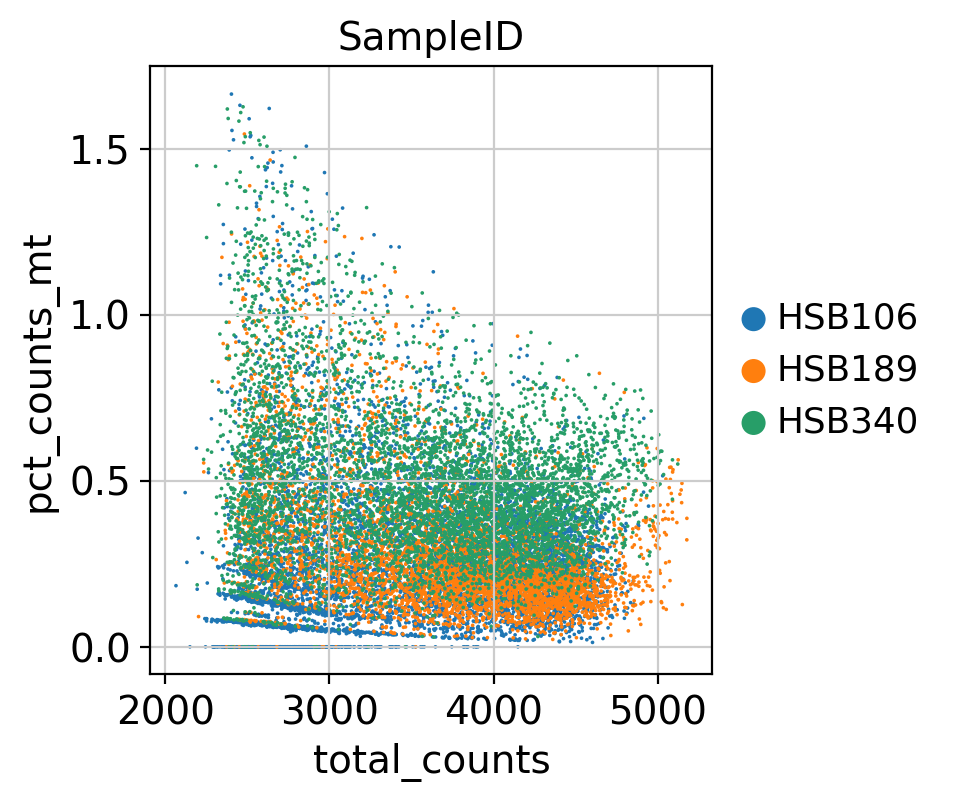

In [77]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [78]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

17093 23476


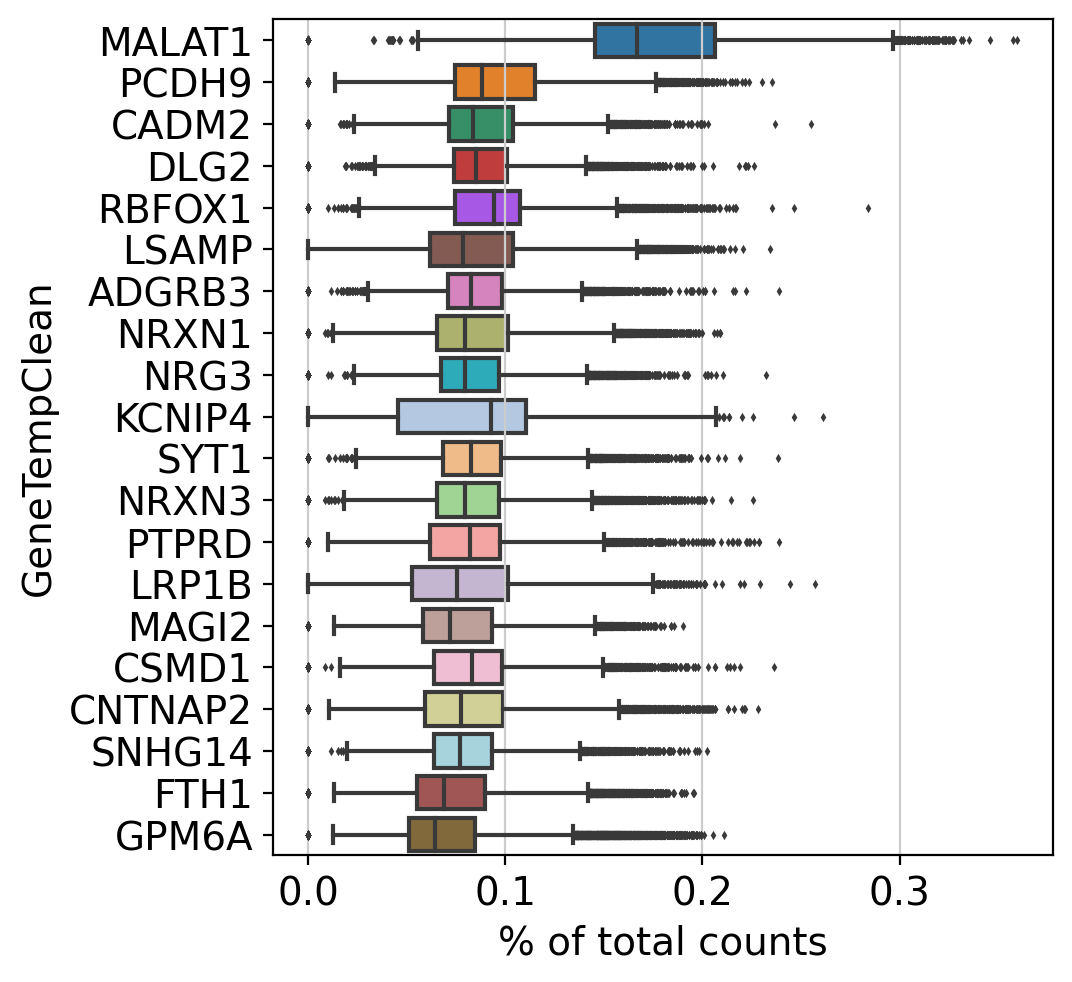

In [79]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [80]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
#adata = adata[adata.obs['pct_counts_ribo'] > 2, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 17093


# Plot filtered QC

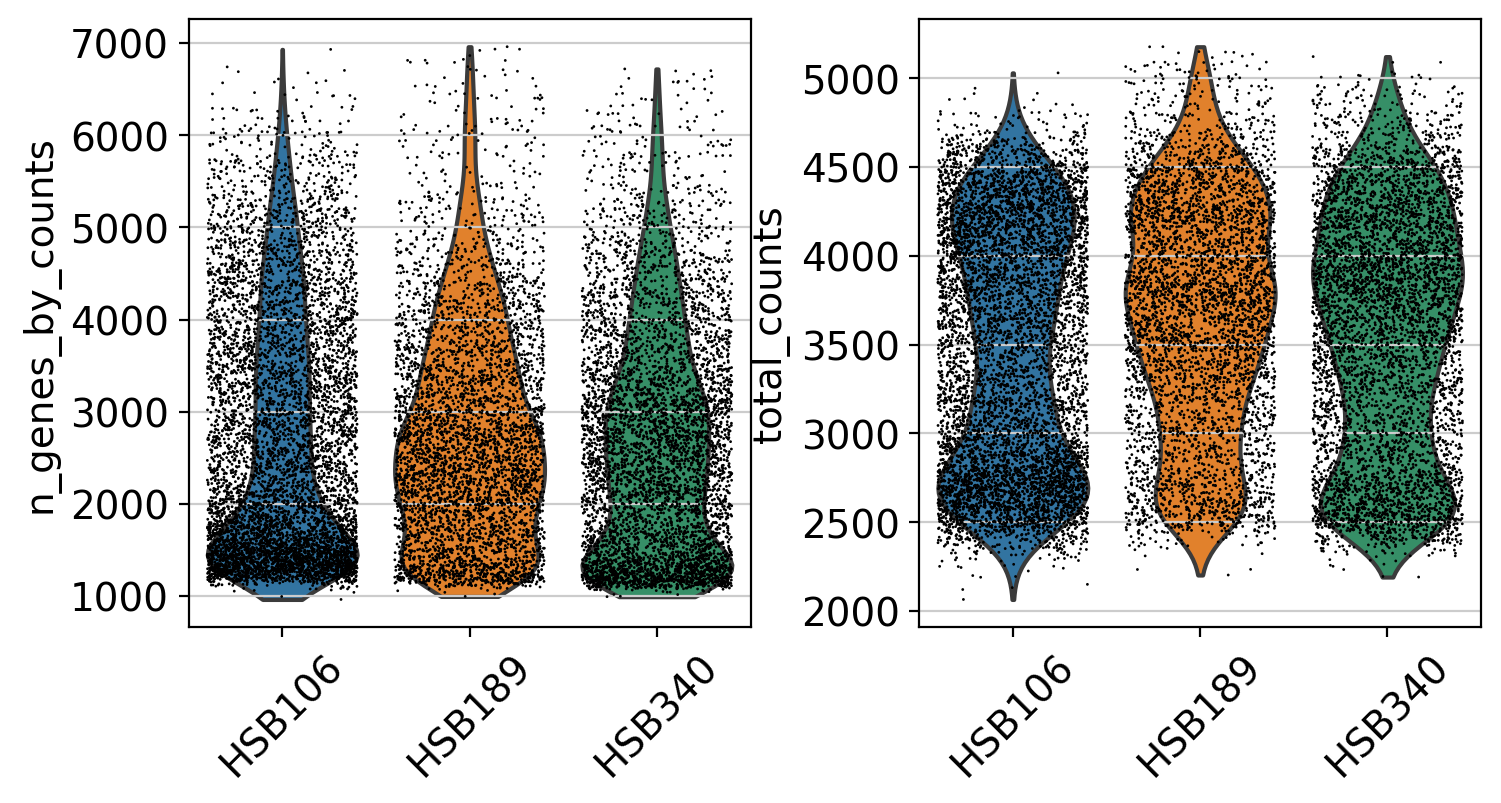

In [81]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

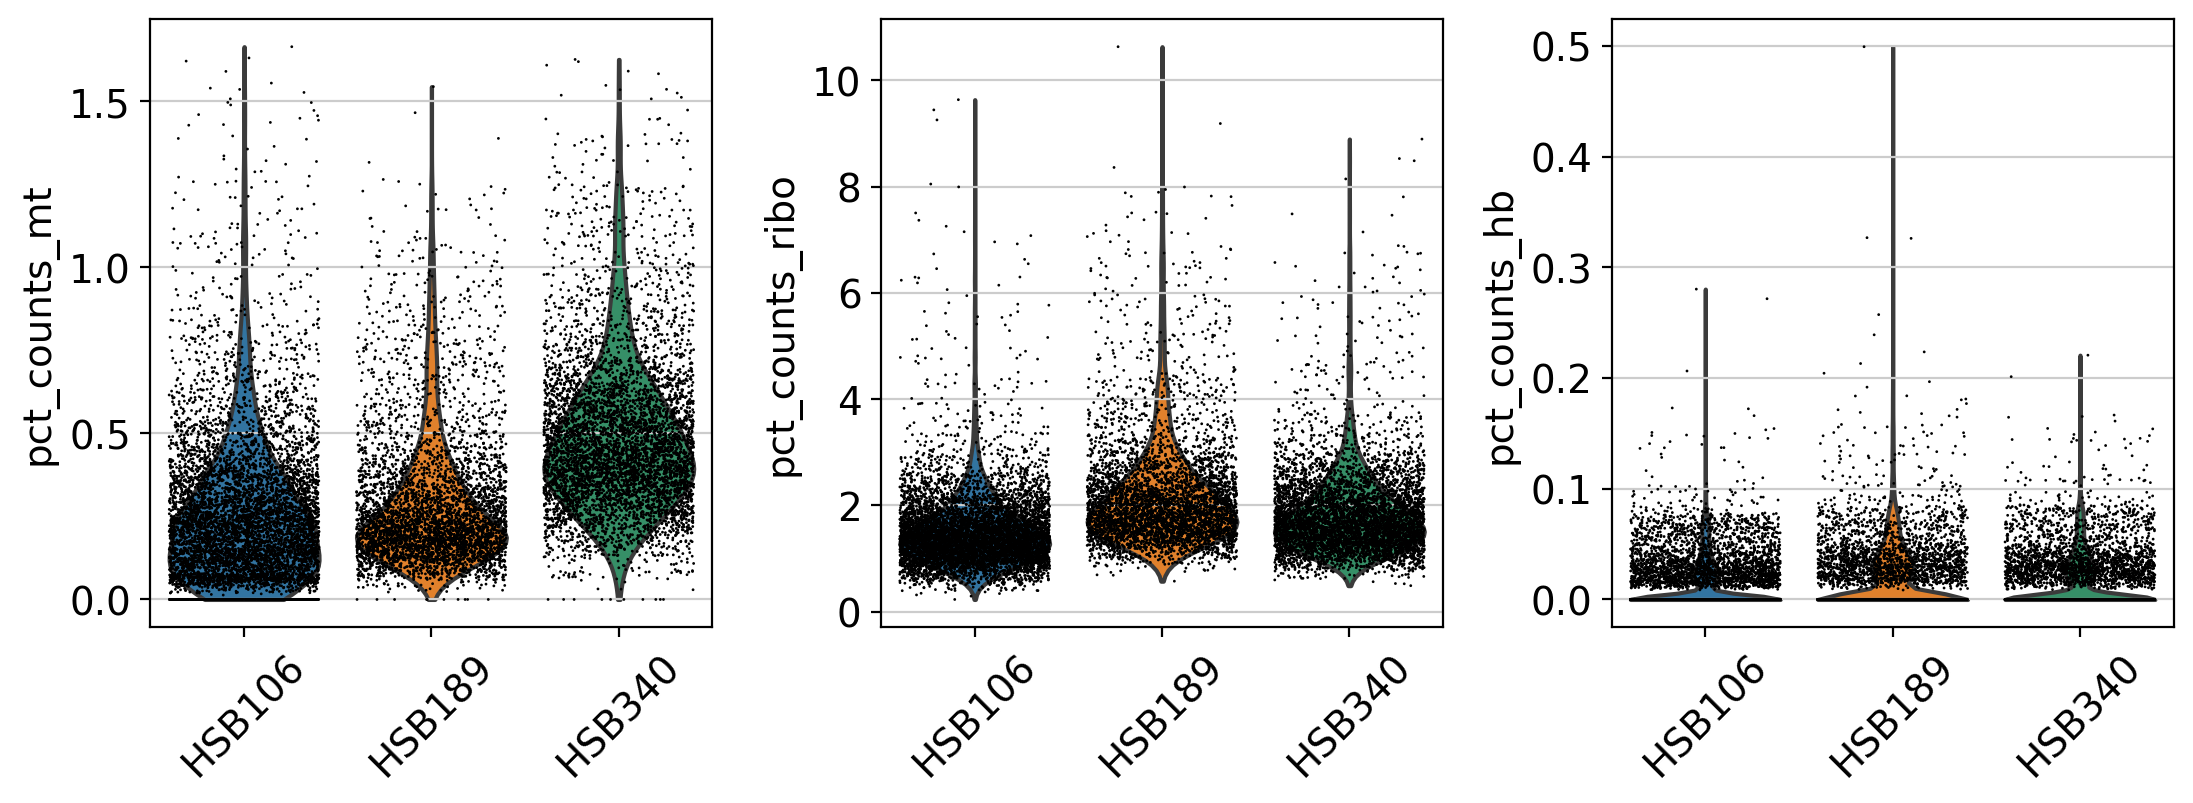

In [82]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [83]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [84]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [85]:
adata = adata[:, ~mito_gene_indicator]

In [86]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

17093 23459
17093 23220


# Calculate cell-cycle scores

In [87]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
81


In [88]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


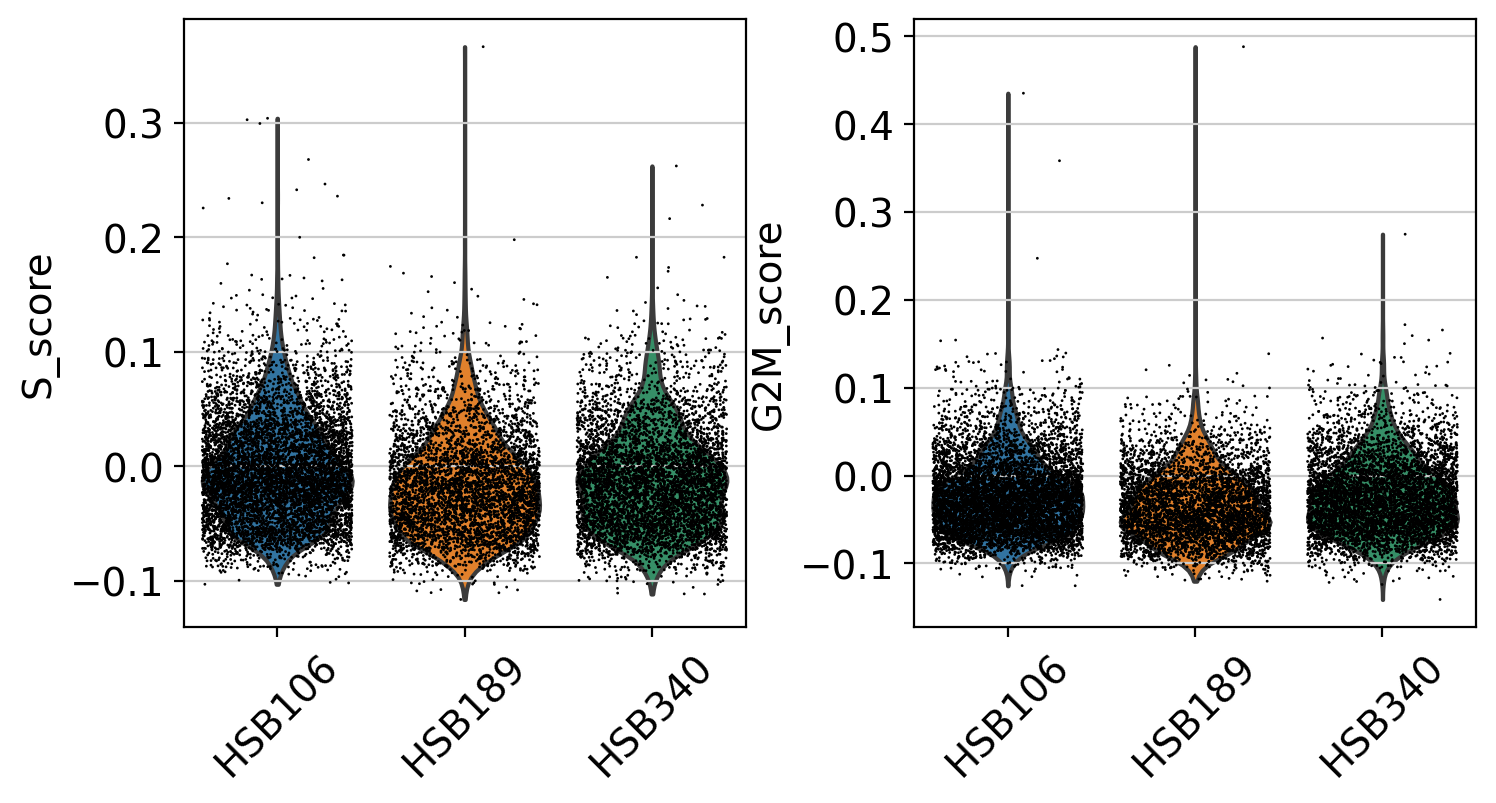

In [89]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 2.6%
Estimated detectable doublet fraction = 66.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.0%
Elapsed time: 18.2 seconds


449

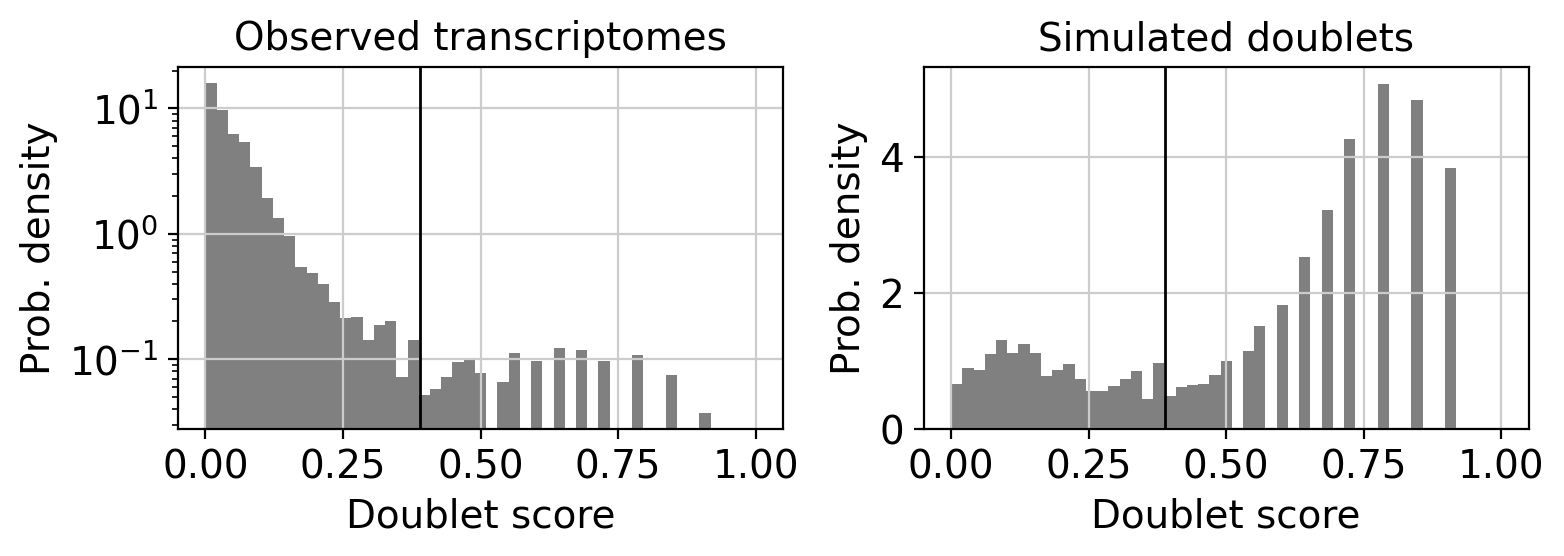

In [90]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [91]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


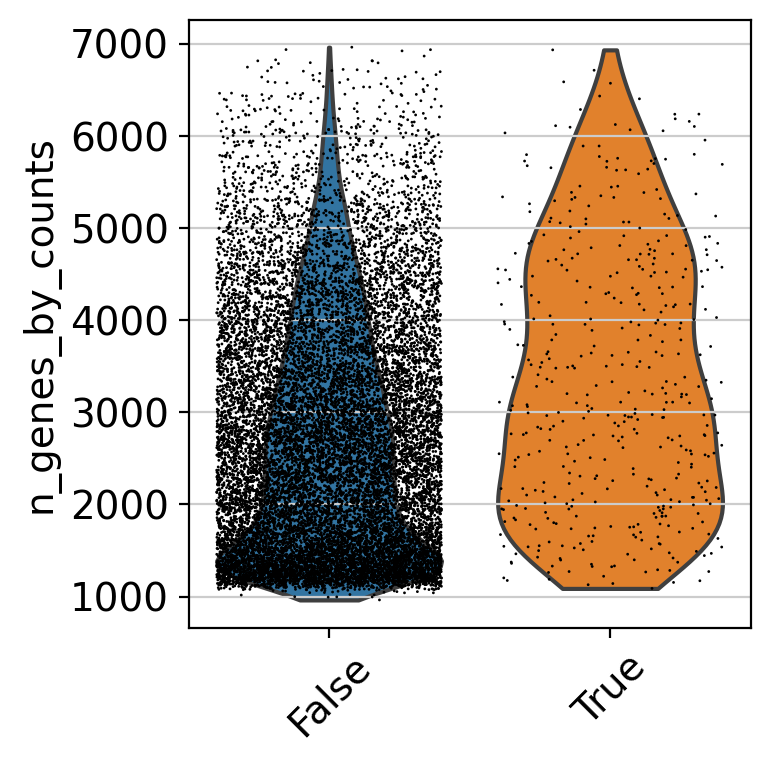

In [92]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [93]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [94]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [95]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [96]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [97]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-13 23:24:08,477 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-13 23:24:11,050 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-13 23:24:13,667 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2022-06-13 23:24:14,897 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


In [98]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [99]:
sc.tl.umap(adata)

In [100]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [101]:
adata

AnnData object with n_obs × n_vars = 16644 × 23220
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [102]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


In [103]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [104]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 16644 cells and 23220 genes
🔗 Matching reference genes in the model
🧬 2428 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [108]:
adata.obs['Age']= adata.obs['Age'].astype(int)

In [109]:
adata.obs['Sample'].value_counts()

PatientPatient56    6753
PatientPatient58    5470
PatientPatient57    4421
Name: Sample, dtype: int64

In [111]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_H_PMID30545854.h5ad")

In [112]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 16644 × 23220
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 

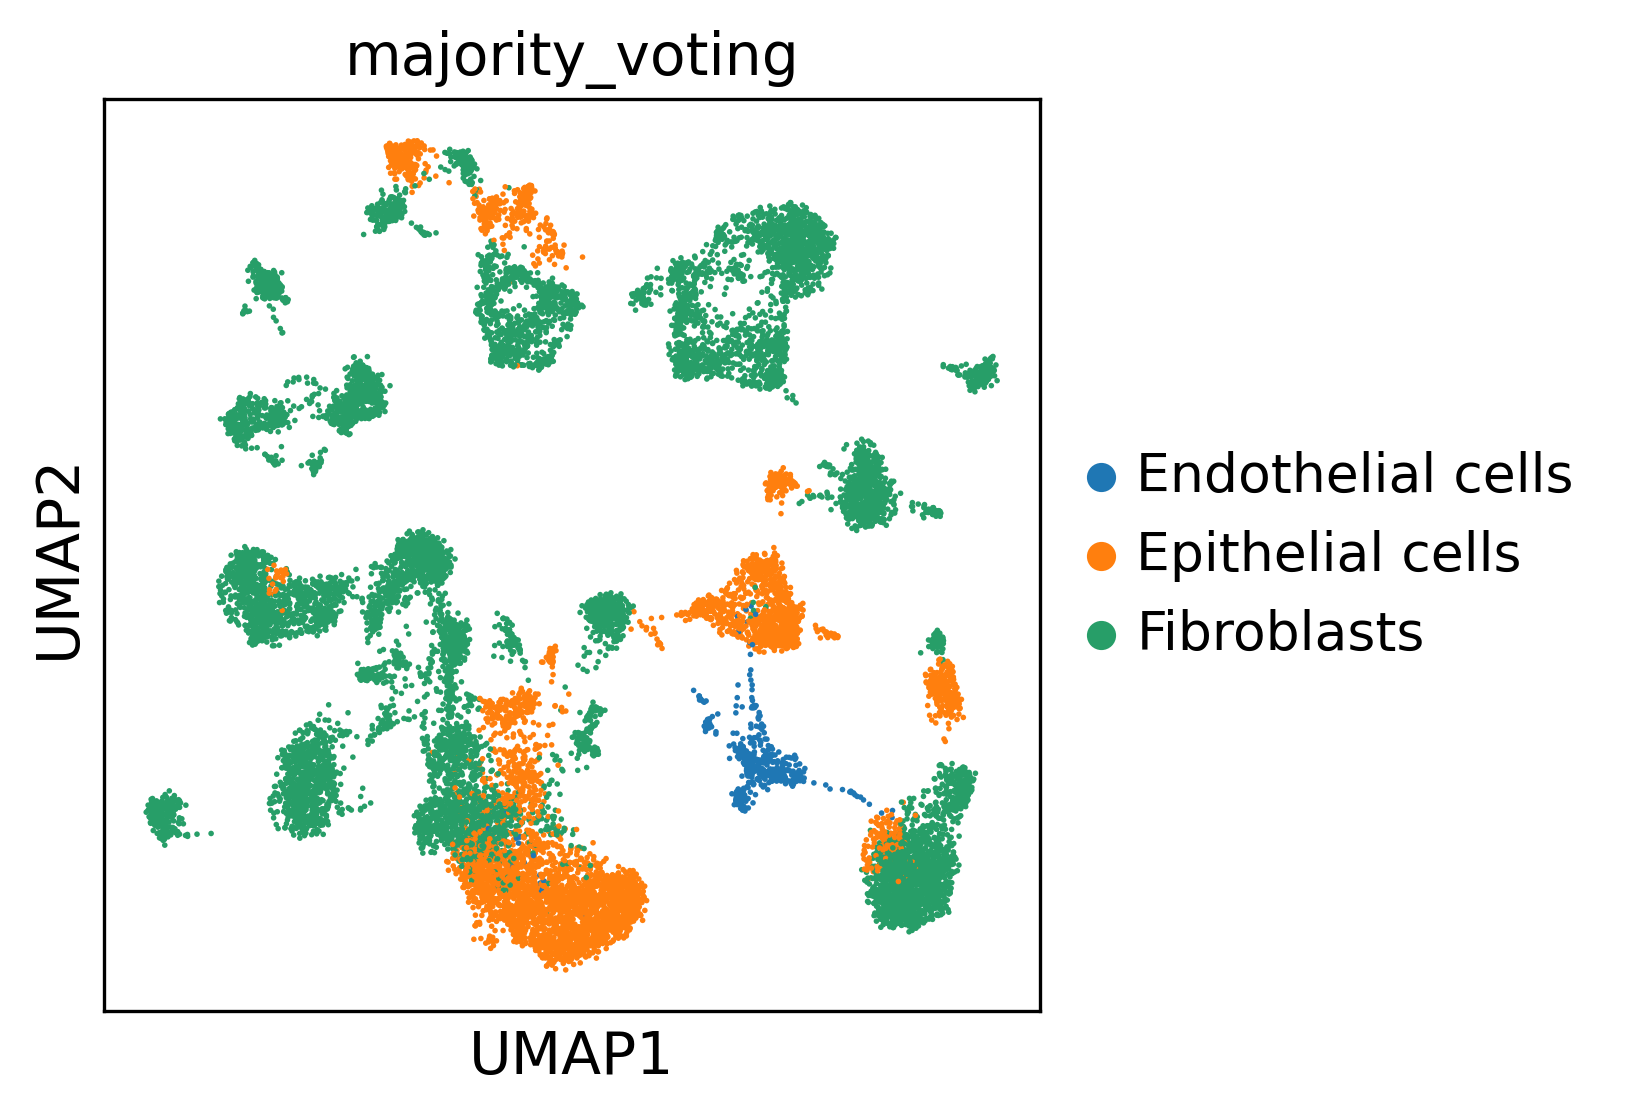

In [113]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [114]:
adata = adata[:, adata.var.highly_variable]

In [115]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [116]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [117]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [118]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

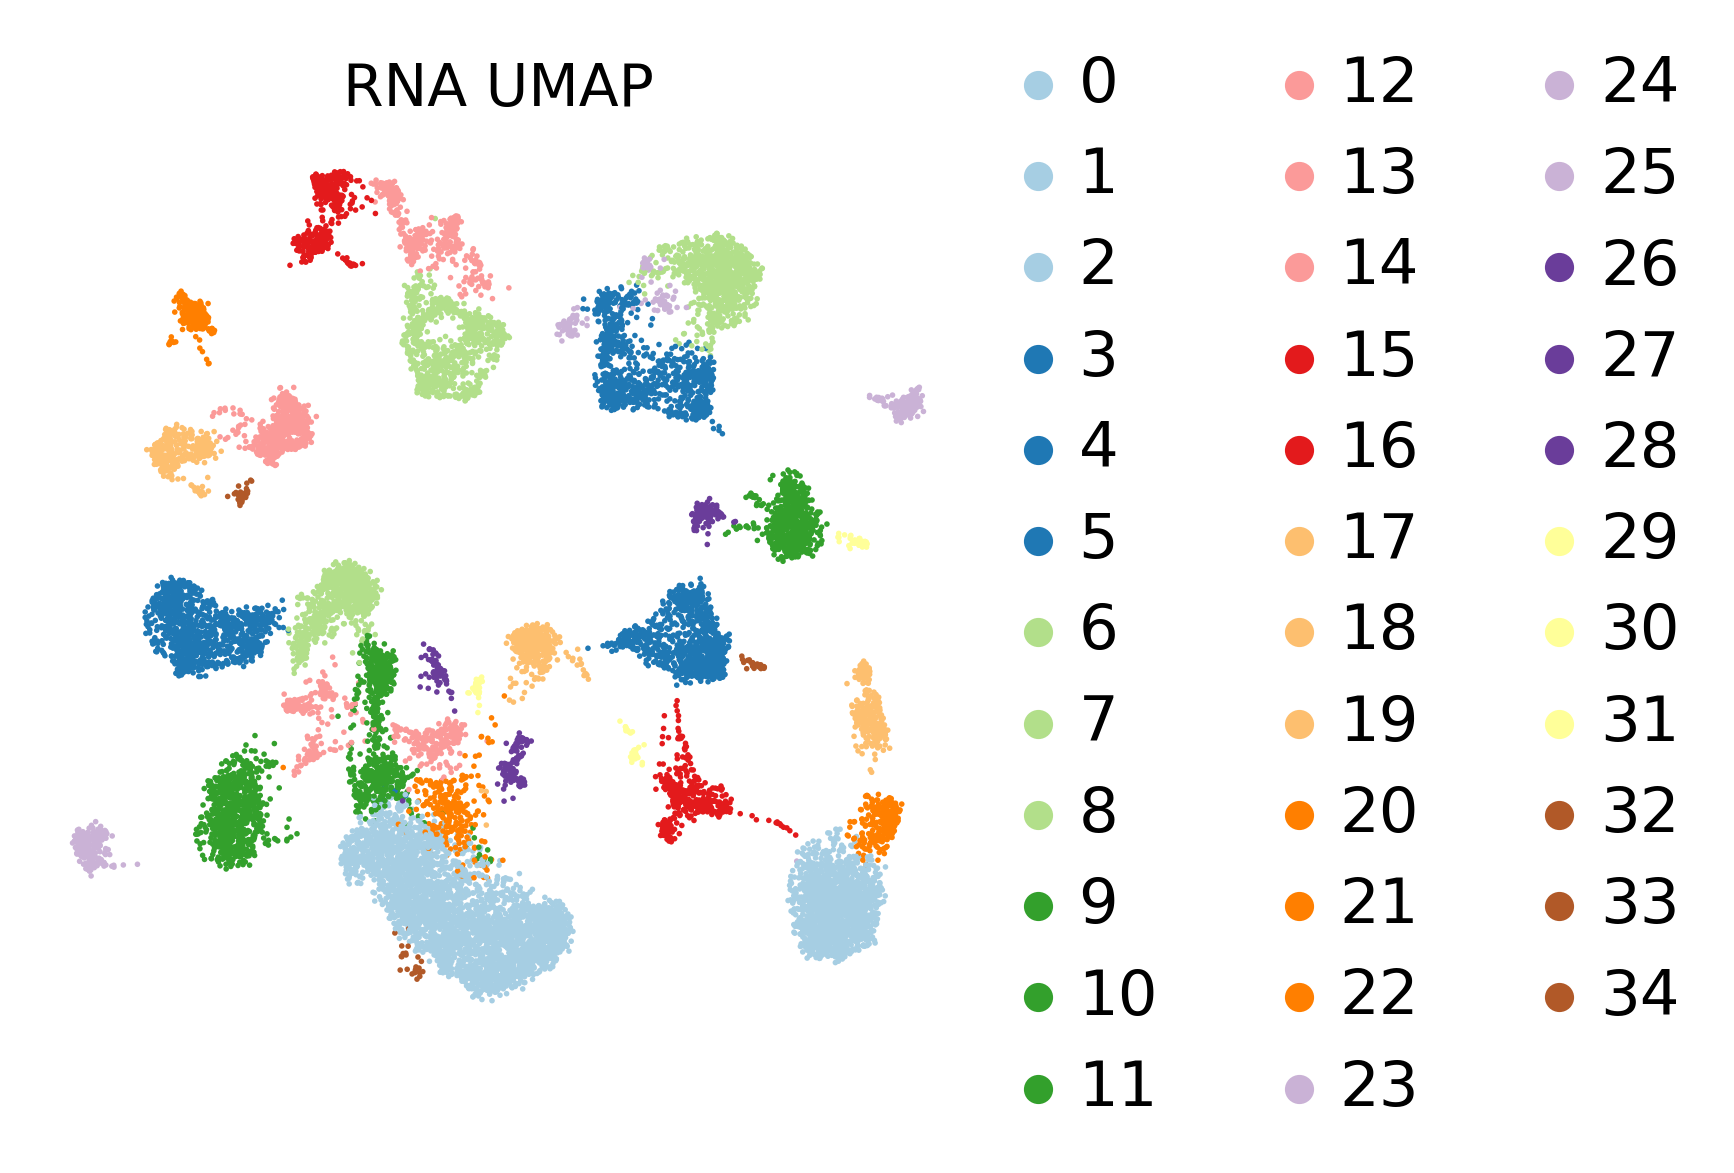

In [119]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [120]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 16644 samples and 5026 targets for 117 sources.


100%|██████████| 16644/16644 [00:06<00:00, 2465.65it/s]


In [121]:
adata.obsm['ora_estimate']

source       Acinar cells  Adipocytes  Alpha cells  Astrocytes   B cells  \
HSB106-0             -0.0    0.383814      0.92403    1.082477  0.712241   
HSB106-2             -0.0    0.383814     -0.00000   -0.000000  0.712241   
HSB106-3             -0.0    1.008395     -0.00000    1.082477  5.777567   
HSB106-4             -0.0    2.723205     -0.00000    0.417218 -0.000000   
HSB106-5             -0.0    1.801150     -0.00000    6.377239 -0.000000   
...                   ...         ...          ...         ...       ...   
HSB340-5615          -0.0   -0.000000      0.92403    2.886927 -0.000000   
HSB340-5616          -0.0    0.383814     -0.00000    5.129396  0.712241   
HSB340-5617          -0.0    0.383814      0.92403    3.962289  0.712241   
HSB340-5618          -0.0    1.801150     -0.00000    0.417218  0.712241   
HSB340-5619          -0.0    0.383814      0.92403    0.417218 -0.000000   

source       B cells memory  B cells naive  Basophils  Bergmann glia  \
HSB106-0           0.613426       0.818118  -0.000000       1.289255   
HSB106-2          -0.000000       0.818118  -0.000000       0.511633   
HSB106-3           1.509334       1.948646  -0.000000       1.289255   
HSB106-4           0.613426      -0.000000   0.565735       3.340858   
HSB106-5          -0.000000      -0.000000   0.565735       8.711884   
...                     ...            ...        ...            ...   
HSB340-5615        0.613426      -0.000000   0.565735       4.548146   
HSB340-5616        1.509334       0.818118   0.565735       3.340858   
HSB340-5617        0.613426      -0.000000   0.565735       3.340858   
HSB340-5618        0.613426       0.818118  -0.000000       2.246391   
HSB340-5619       -0.000000      -0.000000   0.565735      -0.000000   

source       Beta cells  ...  Stromal cells  T cells  T helper cells  \
HSB106-0           -0.0  ...           -0.0     -0.0            -0.0   
HSB106-2           -0.0  ...           -0.0     -0.0            -0.0   
HSB106-3           -0.0  ...           -0.0     -0.0            -0.0   
HSB106-4           -0.0  ...           -0.0     -0.0            -0.0   
HSB106-5           -0.0  ...           -0.0     -0.0            -0.0   
...                 ...  ...            ...      ...             ...   
HSB340-5615        -0.0  ...           -0.0     -0.0            -0.0   
HSB340-5616        -0.0  ...           -0.0     -0.0            -0.0   
HSB340-5617        -0.0  ...           -0.0     -0.0            -0.0   
HSB340-5618        -0.0  ...           -0.0     -0.0            -0.0   
HSB340-5619        -0.0  ...           -0.0     -0.0            -0.0   

source       T regulatory cells  Tanycytes  Taste receptor cells  Thymocytes  \
HSB106-0               -0.00000  -0.000000             -0.000000   -0.000000   
HSB106-2               -0.00000   0.850209              3.030078   -0.000000   
HSB106-3               -0.00000   0.850209             -0.000000   -0.000000   
HSB106-4               -0.00000  -0.000000              1.305754   -0.000000   
HSB106-5               -0.00000   0.850209              1.305754   -0.000000   
...                         ...        ...                   ...         ...   
HSB340-5615            -0.00000  -0.000000             -0.000000   -0.000000   
HSB340-5616            -0.00000   3.398175             -0.000000   -0.000000   
HSB340-5617            -0.00000  -0.000000              1.305754    1.135091   
HSB340-5618            -0.00000   0.850209              1.305754   -0.000000   
HSB340-5619             1.07085   0.850209             -0.000000   -0.000000   

source       Trophoblast progenitor cells  Tuft cells  Urothelial cells  
HSB106-0                             -0.0   -0.000000          -0.00000  
HSB106-2                             -0.0   -0.000000          -0.00000  
HSB106-3                             -0.0   -0.000000          -0.00000  
HSB106-4                             -0.0    1.015558          -0.00000  
HSB106-5                  

In [122]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Alpha cells', 'Astrocytes', 'B cells',
       'B cells memory', 'B cells naive', 'Basophils', 'Bergmann glia',
       'Beta cells',
       ...
       'Stromal cells', 'T cells', 'T helper cells', 'T regulatory cells',
       'Tanycytes', 'Taste receptor cells', 'Thymocytes',
       'Trophoblast progenitor cells', 'Tuft cells', 'Urothelial cells'],
      dtype='object', name='source', length=117)

In [123]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 16644 × 117
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [124]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

Astrocytes  Bergmann glia  Endothelial cells  Fibroblasts  \
0     0.730861       2.528307           0.744605     1.022612   
1     0.747343       2.254509           0.812241     0.701182   
10    0.600605       2.122859           0.742597     1.049869   
11    2.375845       2.189230           0.937667     0.790519   
12    1.623630       2.181161           0.885021     0.808885   
13    0.843452       2.020041           0.652330     1.609967   
14    0.682745       2.477239           0.678551     0.970320   
15    1.810707       3.109406          21.851664     4.461074   
16    0.818277       2.732679           0.569263     1.130074   
17    1.008340       1.620604           1.232914     0.783396   
18    1.146199       2.314233           0.640201     0.766565   
19    5.799346       5.801284           1.079515     1.306264   
2     7.181903       6.132391           0.936372     1.080486   
20    0.716639       2.282294           0.773195     0.767617   
21    6.497678       5.782024           1.554921     1.096849   
22    1.408606       2.577915           0.732958     0.495767   
23    0.472389       1.969562           0.843011     1.362586   
24    1.353397       2.297755           0.718994     0.920174   
25    1.350404       2.260845           0.831636     1.097964   
26    1.969045       2.252094           0.715093     1.194755   
27    3.911437       5.175687           0.661238     0.730069   
28    1.323923       2.711532           0.565508     0.701885   
29    0.914882       1.132219           0.401143     1.689210   
3     0.816389       1.914698           0.619653     0.589930   
30    6.819800       5.702992           0.901615     0.678139   
31    1.476038       1.863814           8.180929     7.910175   
32    1.191955       2.140077           0.860840     1.098132   
33    1.403966       2.745717           1.131350     0.918746   
34    0.965221       2.676551           0.746671     0.999478   
4     0.681615       1.559017           0.605182     0.751202   
5     1.102530       2.227861           1.170446     1.170099   
6     0.940869       1.966994           0.929661     1.044723   
7     0.867006       1.793682           0.630656     1.038391   
8     0.570648       1.693027           0.774352     0.746154   
9     0.546425       2.253523           0.795026     0.848137   

    GABAergic neurons  Hepatic stellate cells  Interneurons  Mast cells  \
0            0.267698                0.086880      1.271050    5.491698   
1            0.409596                0.130453      1.208771    5.121281   
10           0.154910                0.108025      1.109094    3.945590   
11           0.456971                0.150180      1.178831    3.387910   
12           0.226626                0.088097      1.729736    5.348389   
13           3.075901                0.094360      5.005193    4.841689   
14           0.214135                0.047560      1.157047    4.863793   
15           0.530686                2.846016      0.206611    2.744866   
16           3.137740                0.063190      4.433625    4.500095   
17           0.374111                0.218102      1.395543    1.845158   
18           0.484829                0.118329      1.914202    5.508620   
19           0.312019                0.106849      0.262982    3.293576   
2            0.452107                0.197882      0.445752    3.168352   
20           0.267628                0.111087      1.359359    4.468267   
21           0.368803                0.340752      0.365540    2.832586   
22           0.213484                0.124305      1.515916    4.647305   
23           0.083465                0.034088      1.685984    4.124057   
24           2.011201                0.064206      2.895107    4.660673   
25           2.530433                0.086652      2.846878    4.974300   
26           0.210586                0.058065      0.705815    3.298697   
27           0.173957                0.059709      1.134295    4.705134   
28           

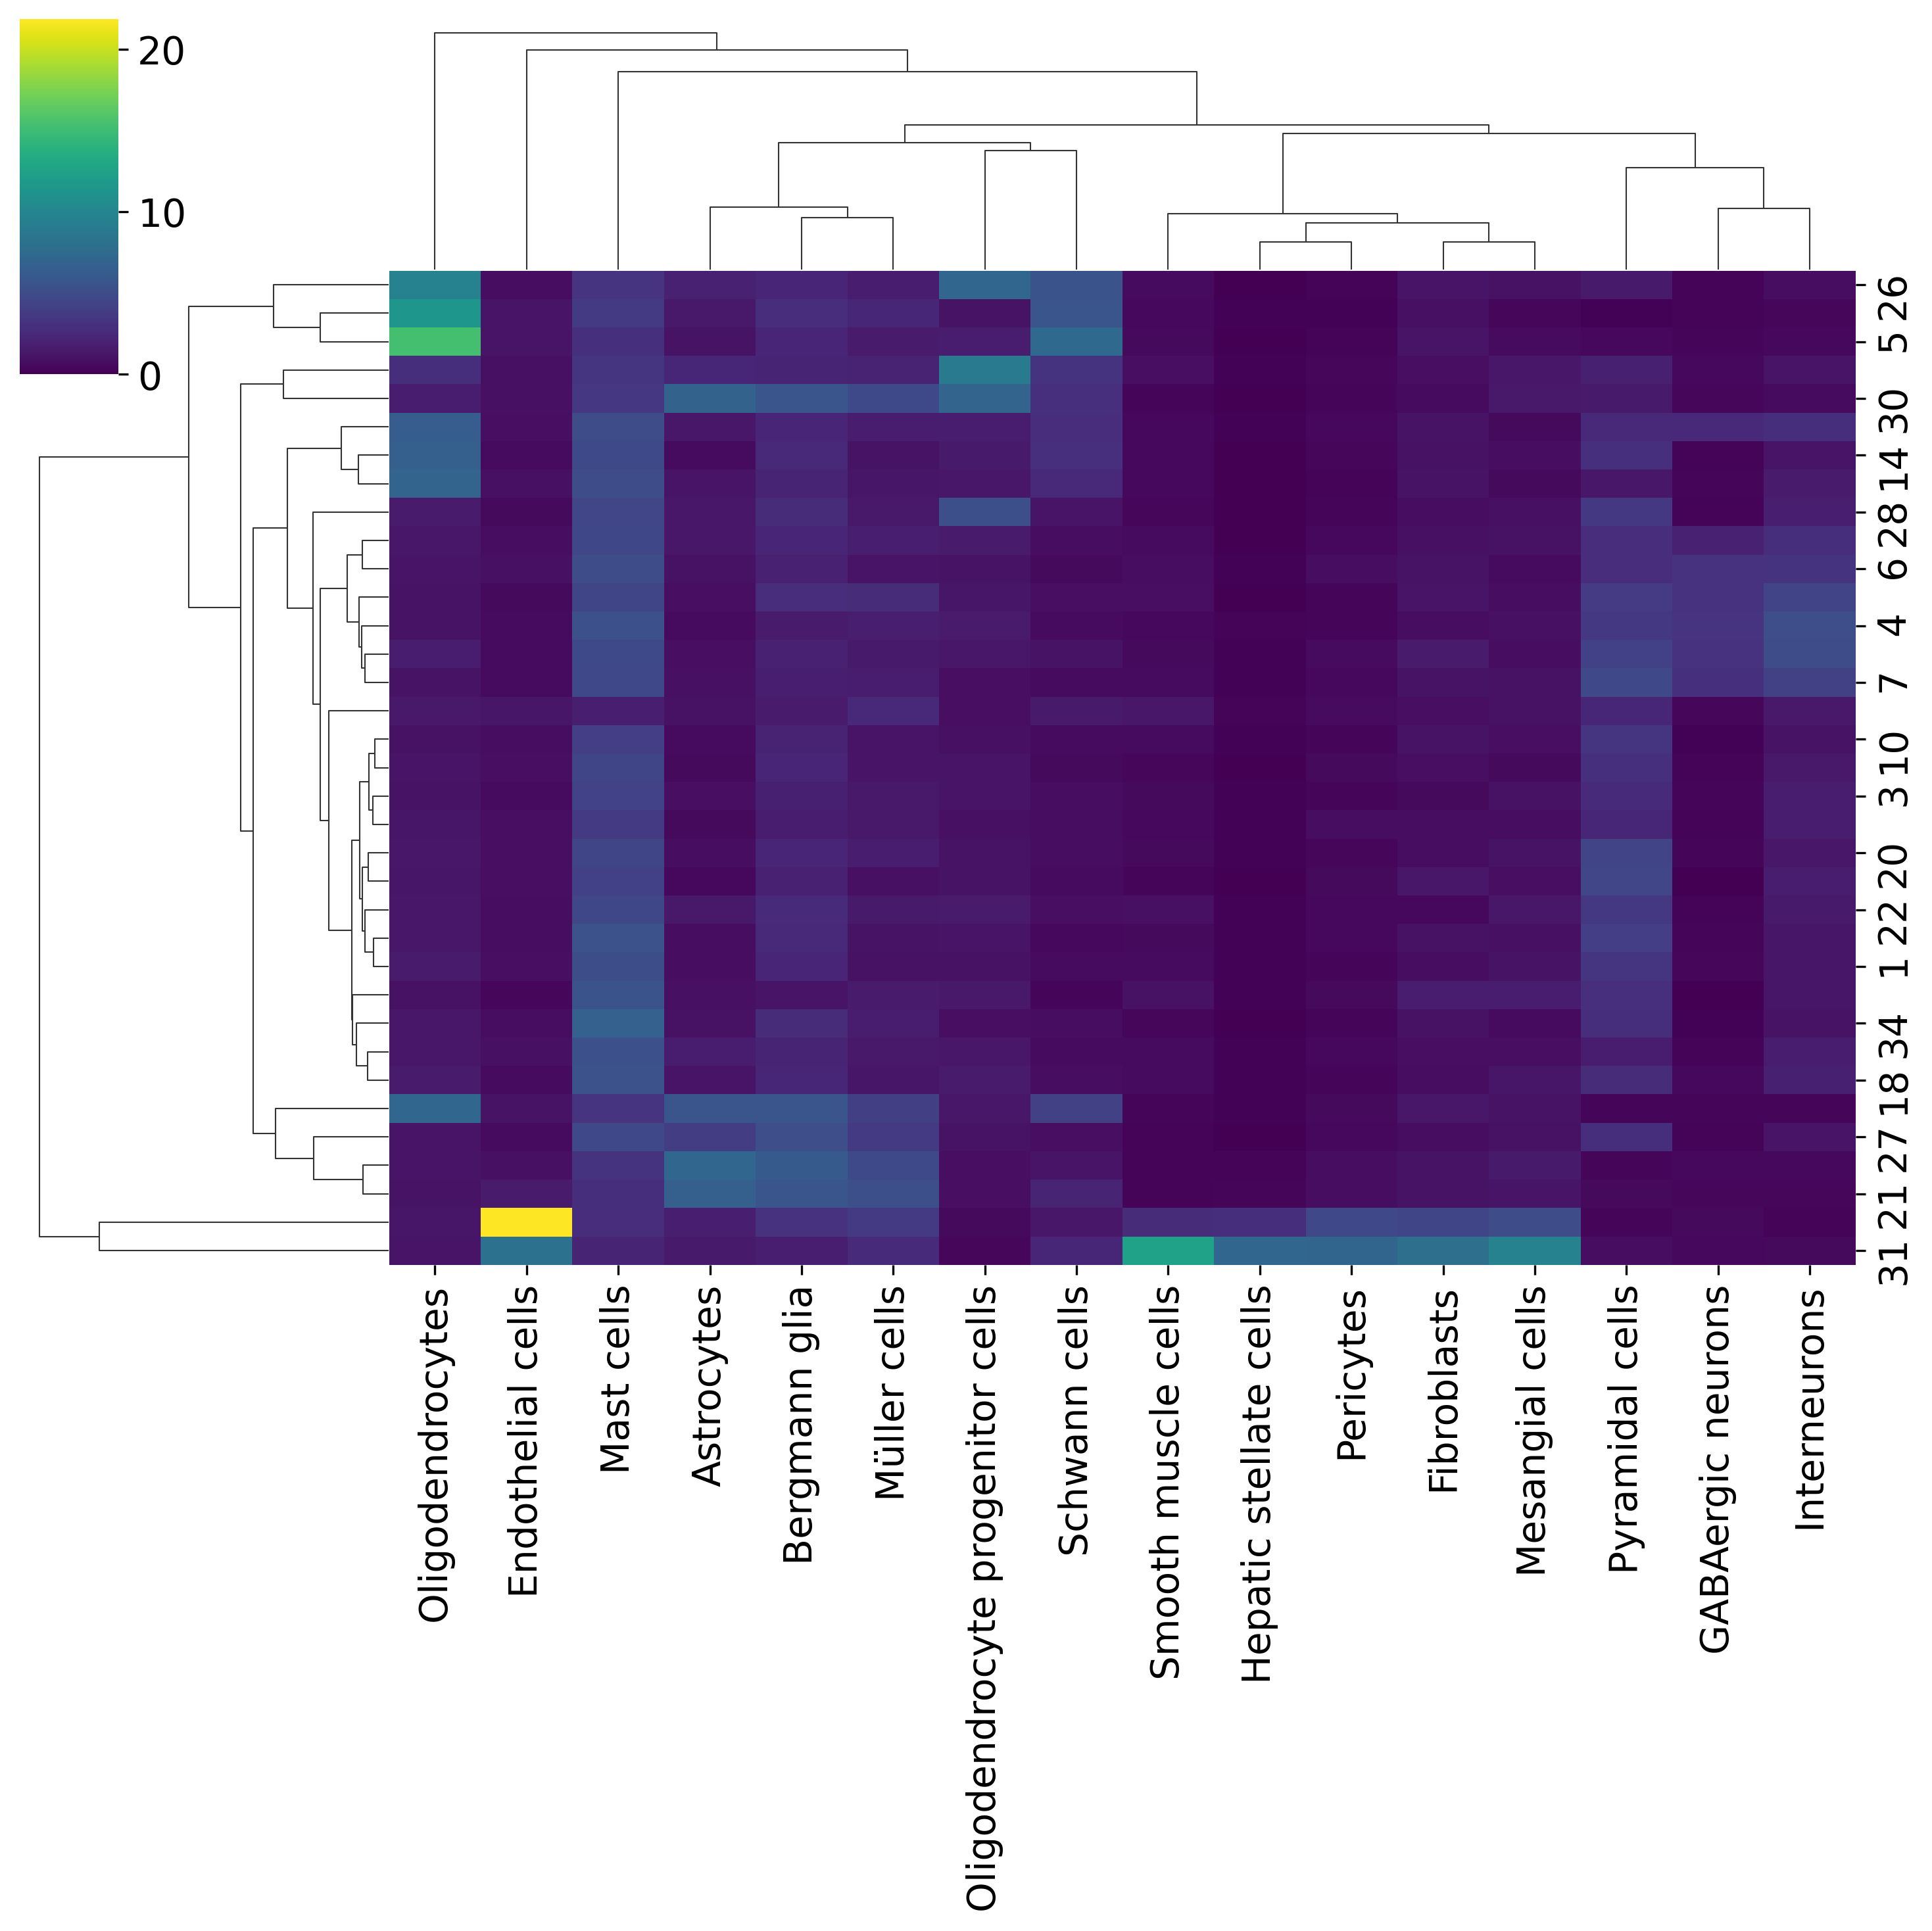

In [125]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [126]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Mast cells',
 '1': 'Mast cells',
 '10': 'Mast cells',
 '11': 'Oligodendrocyte progenitor cells',
 '12': 'Mast cells',
 '13': 'Interneurons',
 '14': 'Oligodendrocytes',
 '15': 'Endothelial cells',
 '16': 'Mast cells',
 '17': 'Müller cells',
 '18': 'Mast cells',
 '19': 'Oligodendrocytes',
 '2': 'Astrocytes',
 '20': 'Mast cells',
 '21': 'Astrocytes',
 '22': 'Mast cells',
 '23': 'Pyramidal cells',
 '24': 'Mast cells',
 '25': 'Oligodendrocytes',
 '26': 'Oligodendrocytes',
 '27': 'Bergmann glia',
 '28': 'Oligodendrocyte progenitor cells',
 '29': 'Mast cells',
 '3': 'Mast cells',
 '30': 'Oligodendrocyte progenitor cells',
 '31': 'Smooth muscle cells',
 '32': 'Oligodendrocytes',
 '33': 'Oligodendrocytes',
 '34': 'Mast cells',
 '4': 'Mast cells',
 '5': 'Oligodendrocytes',
 '6': 'Mast cells',
 '7': 'Mast cells',
 '8': 'Mast cells',
 '9': 'Mast cells'}

... storing 'cell_type' as categorical


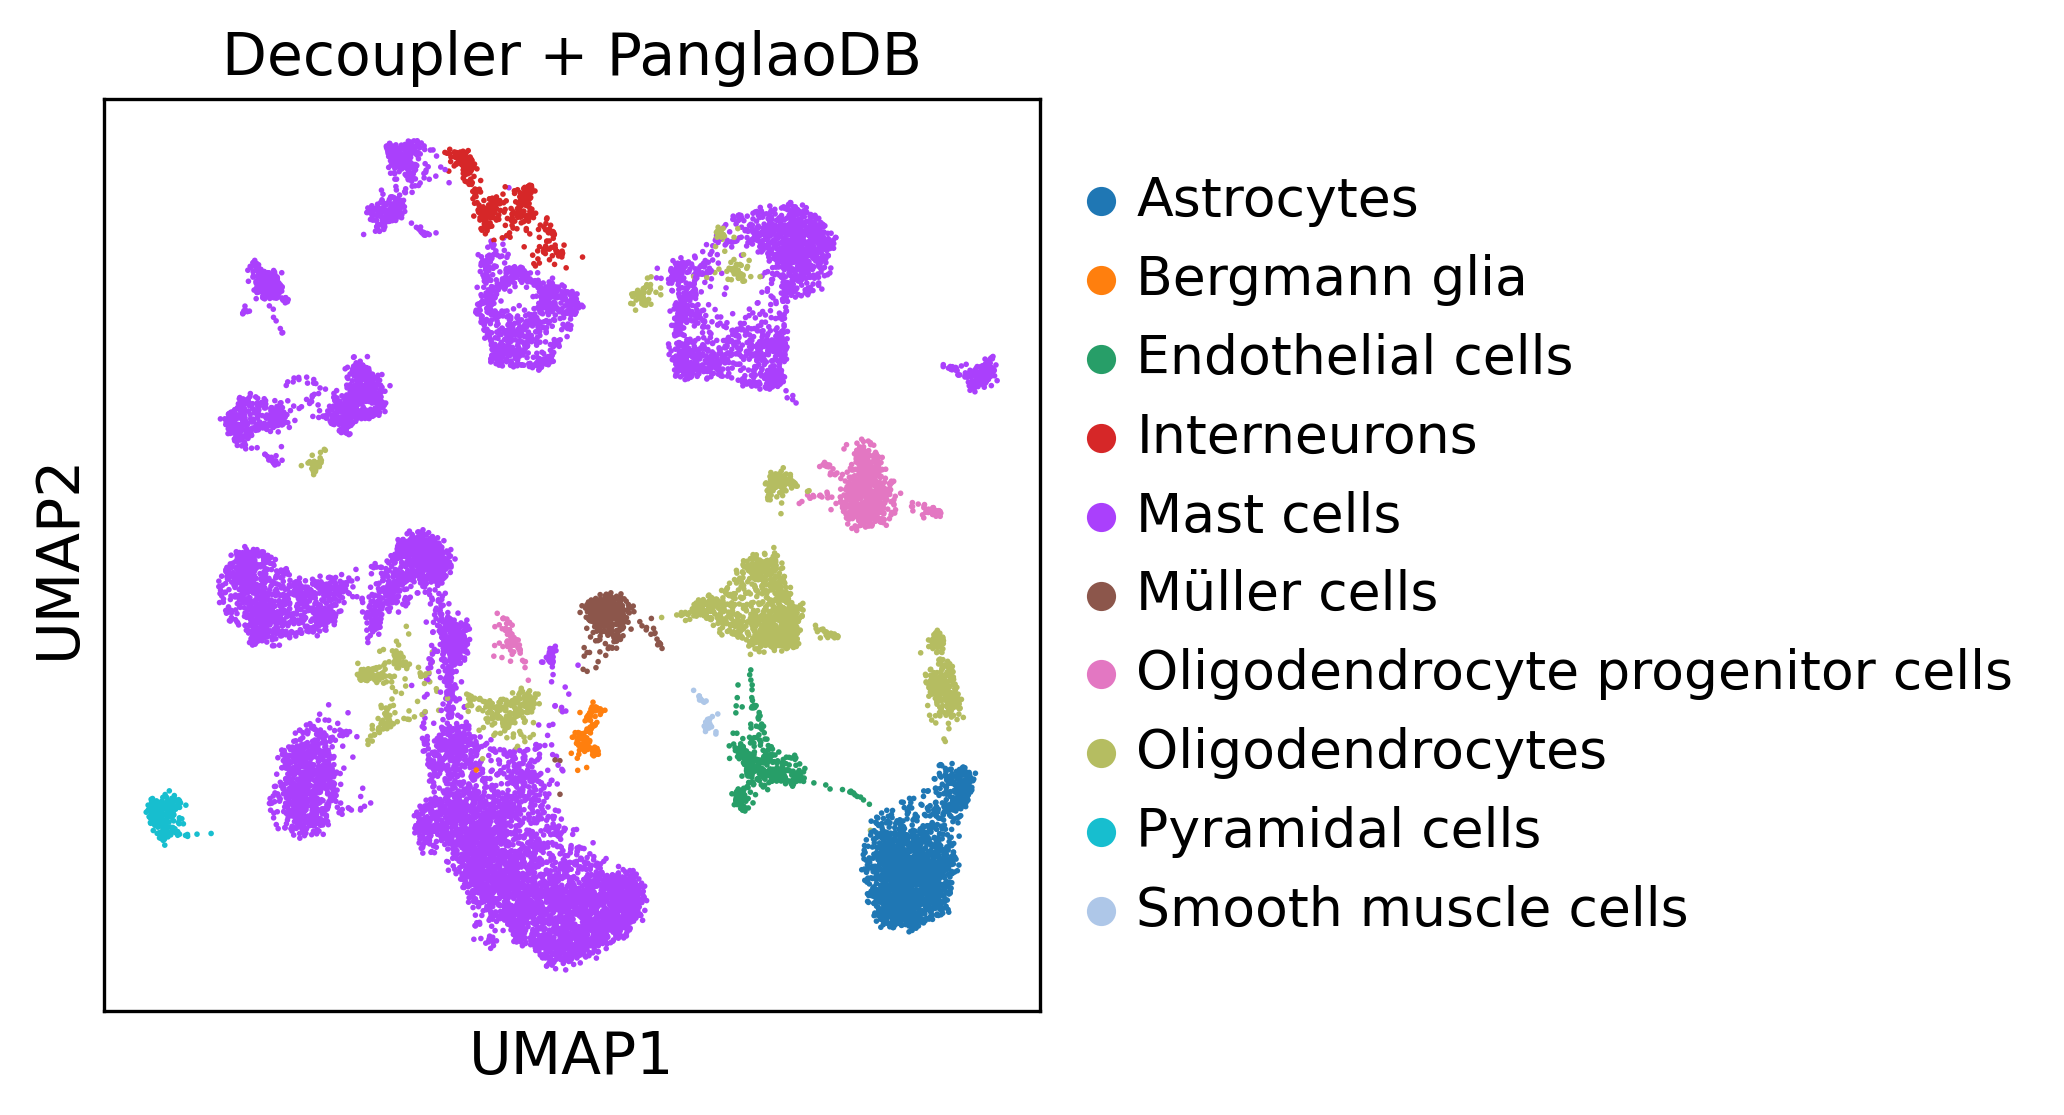

In [127]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [128]:
adata

AnnData object with n_obs × n_vars = 16644 × 5026
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X

In [129]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_H_PMID30545854.h5ad")